In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
def nominal_dist(x1, x2, nominal_cols):
    l = len(nominal_cols)
    n = sum(x1[nominal_cols] == x2[nominal_cols])
    return (l - n) / l

In [3]:
def numeric_dist(x1, x2, column_name, df):
    min_val = df[column_name].min()
    max_val = df[column_name].max()
    if max_val == min_val:  
        return 0
    return abs(x1 - x2) / (max_val - min_val)

In [4]:
def compute_matrix(group, nominal_cols):
    numeric_cols = ['Units', 'Unit_price', 'Sale_amt']
    group_numeric = group[numeric_cols].values
    group_nominal = group[nominal_cols]

    num_records = group.shape[0]
    combined_dist = np.zeros((num_records, num_records))

    for i in range(num_records):
        for j in range(i + 1, num_records):
            total_numeric_dist = 0
            for col in numeric_cols:
                total_numeric_dist += numeric_dist(group.iloc[i][col], group.iloc[j][col], col, group)
            nominal_distance = nominal_dist(group.iloc[i], group.iloc[j], nominal_cols)
            combined_dist[i, j] = np.round((total_numeric_dist + nominal_distance) / (len(numeric_cols) + 1),2)
            combined_dist[j, i] = combined_dist[i, j]

    return combined_dist

In [5]:
df = pd.read_excel("Downloads/SaleData UL Lab.xlsx")

In [6]:
nominal_cols = ['Region', 'Manager', 'SalesMan', 'Item']
numeric_cols = ['Units', 'Unit_price', 'Sale_amt']

In [7]:
for col in nominal_cols:
    df[col] = df[col].fillna('Missing').astype('str')

label_encoders = {}
for col in nominal_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [8]:
grouped = df.groupby('Item')

most_dissimilar_pairs = {}
dissimilarity_matrices = {}

In [9]:
for item, group in grouped:
    if group.shape[0] < 2:  
        continue
    dist_matrix = compute_matrix(group, nominal_cols)
    dissimilarity_matrices[item] = dist_matrix
    idx = np.unravel_index(np.nanargmax(dist_matrix), dist_matrix.shape)  
    most_dissimilar_pairs[item] = (group.iloc[idx[0]], group.iloc[idx[1]], dist_matrix[idx])

In [10]:
for item, matrix in dissimilarity_matrices.items():
    item_name = label_encoders['Item'].inverse_transform([item])[0]
    print(f"Dissimilarity Matrix for Item: {item_name}")
    print(pd.DataFrame(matrix, index=grouped.get_group(item).index, columns=grouped.get_group(item).index))
    print("\n")

Dissimilarity Matrix for Item: Cell Phone
      3     17    18    28    37
3   0.00  0.42  0.26  0.61  0.43
17  0.42  0.00  0.43  0.26  0.26
18  0.26  0.43  0.00  0.62  0.56
28  0.61  0.26  0.62  0.00  0.31
37  0.43  0.26  0.56  0.31  0.00


Dissimilarity Matrix for Item: Desk
      14    31    35
14  0.00  0.62  0.35
31  0.62  0.00  0.52
35  0.35  0.52  0.00


Dissimilarity Matrix for Item: Home Theater
      1     5     9     11    12    16    22    23    24    25    30    38  \
1   0.00  0.24  0.24  0.30  0.36  0.18  0.15  0.33  0.44  0.43  0.29  0.23   
5   0.24  0.00  0.00  0.23  0.24  0.37  0.27  0.34  0.31  0.48  0.30  0.20   
9   0.24  0.00  0.00  0.23  0.24  0.37  0.27  0.34  0.31  0.48  0.30  0.20   
11  0.30  0.23  0.23  0.00  0.41  0.19  0.28  0.51  0.20  0.31  0.47  0.34   
12  0.36  0.24  0.24  0.41  0.00  0.48  0.38  0.16  0.55  0.60  0.19  0.26   
16  0.18  0.37  0.37  0.19  0.48  0.00  0.22  0.45  0.32  0.30  0.41  0.35   
22  0.15  0.27  0.27  0.28  0.38  0.22  0.00  

In [11]:
print("Most dissimilar pairs for each group:")
for item, (point1, point2, dist) in most_dissimilar_pairs.items():
    item_name = label_encoders['Item'].inverse_transform([item])[0]
    print(f"Item: {item_name}")
    print(f"Point 1: {point1}")
    print(f"Point 2: {point2}")
    print(f"Dissimilarity: {dist}\n")

Most dissimilar pairs for each group:
Item: Cell Phone
Point 1: OrderDate     2018-11-08 00:00:00
Region                          1
Manager                         0
SalesMan                        4
Item                            0
Units                          15
Unit_price                    225
Sale_amt                     3375
Name: 18, dtype: object
Point 2: OrderDate     2019-04-27 00:00:00
Region                          1
Manager                         2
SalesMan                        2
Item                            0
Units                          96
Unit_price                    225
Sale_amt                    21600
Name: 28, dtype: object
Dissimilarity: 0.62

Item: Desk
Point 1: OrderDate     2018-09-01 00:00:00
Region                          0
Manager                         0
SalesMan                        3
Item                            1
Units                           2
Unit_price                    125
Sale_amt                      250
Name: 14, dtype: objec

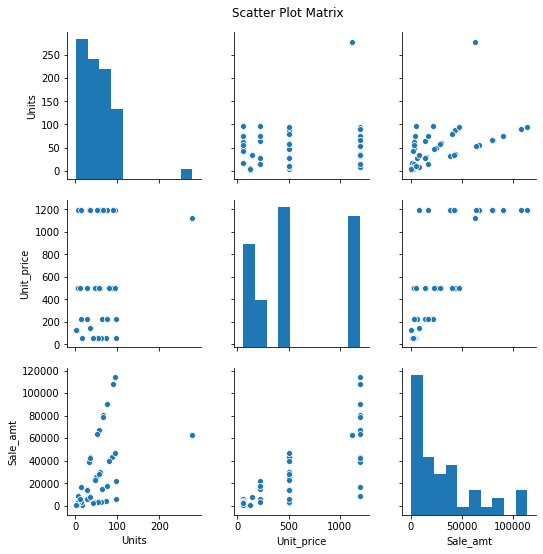

In [12]:
sns.pairplot(df[numeric_cols])
plt.suptitle("Scatter Plot Matrix", y=1.02)
plt.show()

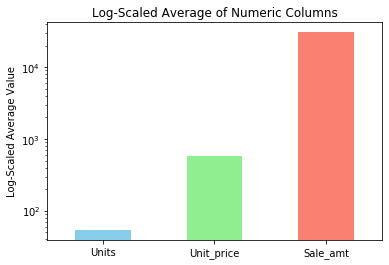

In [13]:
df[numeric_cols].mean().plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.yscale('log')
plt.title("Log-Scaled Average of Numeric Columns")
plt.ylabel('Log-Scaled Average Value')
plt.xticks(rotation=0)
plt.show()
